In [1]:
import tensorflow as tf
print(tf.__version__)

# !pip install -q tensorflow-datasets

2.5.0


In [2]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteURCT2N/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteURCT2N/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteURCT2N/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


# 리뷰 문장을 토큰화 하는 법

문장을 토큰화 하고 시퀀스로 변환하는 과정입니다.

In [4]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)


우선 토큰화 할 단어의 수와, 최대길이와 같은 하이퍼 파라미터들을 지정해 줍니다. 
그리고 Tonkenizer와 pad_sequences()함수를 불러옵니다.

fit_on_texts를 이용하여 단어들을 토큰화 하고, text_to_sequences를 이용해서 숫자의 시퀀스로 다시 변환을 합니다. 

pad_sequences는 Neural Network의 훈련에 적합하도록 이 시퀀스의 길이를 일정하게 만들어줍니다.

In [5]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[3]))
print(training_sentences[3])

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? this is the kind of film for a snowy sunday afternoon when the rest of the world can go ahead with its own business as you <OOV> into a big arm chair and <OOV> for a couple of hours wonderful performances from cher and nicolas cage as always gently row the plot along there are no <OOV> to cross no dangerous waters just a warm and witty <OOV> through new york life at its best a family film in every sense and one that deserves the praise it received
This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.


# 모델을 구성하기

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 11526     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


Emdedding 레이어는 우리가 할 텍스트 감정 분석에 있어서 가장 핵심적인 부분인데, 임베딩의 결과는 (vocab_size, embedding_dim)의 형태를 갖는 2차원 어레이가 되고, 이전에 했던 이미지 분류 문제와 마찬가지로 Flatten 레이어를 사용해서 이 2차원 어레이를 1차원으로 변화하게 됩니다.

In [7]:
num_epochs = 10
model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 4s 5ms/step - loss: 0.5026 - accuracy: 0.7378 - val_loss: 0.3523 - val_accuracy: 0.8436
Epoch 2/10
782/782 [==============================] - 4s 5ms/step - loss: 0.2329 - accuracy: 0.9108 - val_loss: 0.3672 - val_accuracy: 0.8392
Epoch 3/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0815 - accuracy: 0.9802 - val_loss: 0.4685 - val_accuracy: 0.8235
Epoch 4/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0185 - accuracy: 0.9977 - val_loss: 0.5229 - val_accuracy: 0.8298
Epoch 5/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0047 - accuracy: 0.9998 - val_loss: 0.5816 - val_accuracy: 0.8303
Epoch 6/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0017 - accuracy: 0.9999 - val_loss: 0.6280 - val_accuracy: 0.8319
Epoch 7/10
782/782 [==============================] - 4s 5ms/step - loss: 7.8551e-04 - accuracy: 1.0000 - val_loss: 0.6684 - val_accuracy: 0.8316
Ep

In [8]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [9]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [10]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
sentence = "I really think this is amazing. honest."
sequence = tokenizer.texts_to_sequences([sentence])
print(sequence)

[[11, 64, 102, 12, 7, 478, 1200]]


# Predcit

In [3]:
# Run this to ensure TensorFlow 2.x is used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [4]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000


In [6]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json


--2021-08-05 20:01:55--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.213.128, 173.194.214.128, 173.194.215.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.213.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.03s   

2021-08-05 20:01:55 (195 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [7]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

  

In [8]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [9]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [10]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [12]:

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


Embedding 레어이는 텍스트의 감정 분석에 있어서 핵심적인 부분입니다.

임베딩의 결과는 (vocab_size, embedding_dim)의 형태를 갖는 2차원 어레이가 되고,

이미지 분류 문제에서와 마찬가지로 Flatten 레이어를 사용해서 이 2차원 어레이를 1차원으로 변환합니다.


In [13]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 3s - loss: 0.6676 - accuracy: 0.5763 - val_loss: 0.5904 - val_accuracy: 0.6925
Epoch 2/30
625/625 - 2s - loss: 0.4387 - accuracy: 0.8230 - val_loss: 0.3884 - val_accuracy: 0.8405
Epoch 3/30
625/625 - 2s - loss: 0.3149 - accuracy: 0.8756 - val_loss: 0.3597 - val_accuracy: 0.8448
Epoch 4/30
625/625 - 2s - loss: 0.2655 - accuracy: 0.8947 - val_loss: 0.3435 - val_accuracy: 0.8556
Epoch 5/30
625/625 - 2s - loss: 0.2279 - accuracy: 0.9115 - val_loss: 0.3432 - val_accuracy: 0.8574
Epoch 6/30
625/625 - 2s - loss: 0.2017 - accuracy: 0.9234 - val_loss: 0.3514 - val_accuracy: 0.8526
Epoch 7/30
625/625 - 2s - loss: 0.1797 - accuracy: 0.9334 - val_loss: 0.3826 - val_accuracy: 0.8395
Epoch 8/30
625/625 - 2s - loss: 0.1630 - accuracy: 0.9395 - val_loss: 0.3746 - val_accuracy: 0.8535
Epoch 9/30
625/625 - 2s - loss: 0.1468 - accuracy: 0.9474 - val_loss: 0.3860 - val_accuracy: 0.8524
Epoch 10/30
625/625 - 2s - loss: 0.1325 - accuracy: 0.9541 - val_loss: 0.4029 - val_accuracy: 0.8526

30회의 에포크 동안에 훈련을 거치게 되면 훈련 데이터에 대하여 거진 1.0의 정확도를 가지게 되고 테스트 데이터에 대해서는 0.8165의 정확도를 보임을 알 수 있다.

Flatten 레이어 대신에, GlobalAveragePlooing1D레이어를 사용가능하다. 이렇게 사용하게 되면 훈련 과정이 조금 더 빨라지는 대신에 정확도가 조금 감소하게 된다.

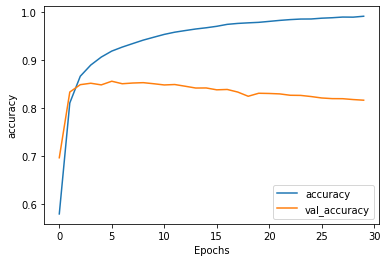

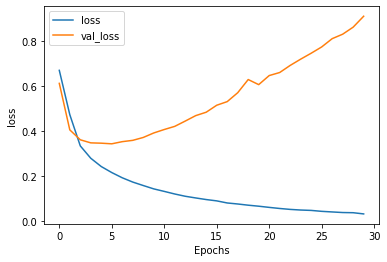

In [24]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [25]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [26]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(10000, 16)


In [27]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [28]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[8.6779690e-01]
 [1.4191866e-04]]
